In [1]:
import os
import skimage
from skimage import io, color ,feature

import numpy as np
import cv2
import re
from skimage.feature import graycomatrix, graycoprops

import pandas as pd

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")


In [4]:
dataset_dir = "/content/drive/My Drive/IIITNR_PROJECT/dataset"
os.listdir(dataset_dir)

['test', 'Train']

In [5]:
import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Initialize lists to store images, labels, and descriptions
imgs = []
labels = []
descs = []

# Function to normalize descriptions (assuming this function is defined elsewhere)
def normalize_desc(folder, sub_folder):
    # Your normalization logic here
    return f"{folder}_{sub_folder}"

# Function to print progress (assuming this function is defined elsewhere)
def print_progress(i, len_sub_folder, folder, sub_folder, filename):
    # Your progress printing logic here
    print(f"Processing {i+1}/{len_sub_folder+1}: {folder}/{sub_folder}/{filename}")

# Function to apply NLM denoising technique
def apply_nlm_denoising(image):
    return cv2.fastNlMeansDenoising(image, None, 3, 5, 15)

# Initialize a dictionary to store results
results = {'nlm': {'(3, 5, 15)': {'psnr': [], 'ssim': []}}}

# Iterate through the directory structure
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1

        # Process each image file
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # First thresholding
            _, binary1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

            # Find contours
            contours, _ = cv2.findContours(binary1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Get the largest contour (assuming it is the soil region)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get the bounding box of the largest contour
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Crop the image using the bounding box
            cropped_image = gray[y:y+h, x:x+w]

            # Resize the cropped image
            resized = cv2.resize(cropped_image, (0, 0), fx=0.5, fy=0.5)

            # Ensure the resized image is suitable for SSIM calculation
            if min(resized.shape) < 7:
                continue

            # Apply NLM denoising
            denoised = apply_nlm_denoising(resized)

            # Calculate PSNR
            psnr = peak_signal_noise_ratio(resized, denoised)

            # Calculate SSIM with explicit win_size parameter
            win_size = min(resized.shape) if min(resized.shape) % 2 != 0 else min(resized.shape) - 1
            win_size = max(win_size, 1)
            ssim = structural_similarity(resized, denoised, win_size=win_size)

            # Store the PSNR and SSIM values
            results['nlm']['(3, 5, 15)']['psnr'].append(psnr)
            results['nlm']['(3, 5, 15)']['ssim'].append(ssim)

            imgs.append(denoised)
            labels.append(sub_folder)
            descs.append(normalize_desc(folder, sub_folder))

            # Print progress
            print_progress(i, len_sub_folder, folder, sub_folder, filename)

# Calculate the average PSNR and SSIM for the NLM technique with parameters (3, 5, 15)
average_psnr = np.mean(results['nlm']['(3, 5, 15)']['psnr'])
average_ssim = np.mean(results['nlm']['(3, 5, 15)']['ssim'])

# Print the table of average PSNR and SSIM values
print("Technique\tParameters\t\tAverage PSNR\tAverage SSIM")
print(f"nlm\t(3, 5, 15)\t{average_psnr:.4f}\t{average_ssim:.4f}")

# Output the best technique and parameters (since we're only using one technique, it's the best by default)
print(f"\nBest Denoising Method: nlm")
print(f"Best Parameters: (3, 5, 15)")


Processing 1/116: test/Black Soil/Black_1.jpg


/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


Processing 2/116: test/Black Soil/Black_17.jpg
Processing 3/116: test/Black Soil/Black_10.jpg
Processing 4/116: test/Black Soil/Black_11.jpg
Processing 5/116: test/Black Soil/Black_16.jpg
Processing 6/116: test/Black Soil/Black_15.jpg
Processing 7/116: test/Black Soil/Black_14.jpg
Processing 8/116: test/Black Soil/Black_12.jpg
Processing 9/116: test/Black Soil/Black_13.jpg
Processing 10/116: test/Black Soil/Black_31.jpg
Processing 11/116: test/Black Soil/Black_27.jpg
Processing 12/116: test/Black Soil/Black_32.jpg
Processing 13/116: test/Black Soil/Black_25.jpg
Processing 14/116: test/Black Soil/Black_35.jpg
Processing 15/116: test/Black Soil/Black_3.jpg
Processing 16/116: test/Black Soil/Black_33.jpg
Processing 17/116: test/Black Soil/Black_21.jpg
Processing 18/116: test/Black Soil/Black_20.jpg
Processing 19/116: test/Black Soil/Black_36.jpg
Processing 20/116: test/Black Soil/Black_18.jpg
Processing 21/116: test/Black Soil/Black_2.jpg
Processing 22/116: test/Black Soil/Black_34.jpg
Pr

In [6]:
len(imgs)

1557

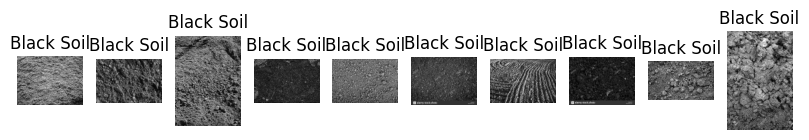

In [7]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(imgs, labels, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(imgs))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(imgs[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Call the function to display images
display_images(imgs, labels)


In [8]:
# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):

    glcm = graycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label)

    return feature



In [9]:
# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")


In [10]:
# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls,
                      columns = columns)

In [11]:
#knowing dataset
type(glcm_df)
len(glcm_df)
glcm_df.shape

(1557, 25)

In [12]:
 glcm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557 entries, 0 to 1556
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dissimilarity_0    1557 non-null   float64
 1   dissimilarity_45   1557 non-null   float64
 2   dissimilarity_90   1557 non-null   float64
 3   dissimilarity_135  1557 non-null   float64
 4   correlation_0      1557 non-null   float64
 5   correlation_45     1557 non-null   float64
 6   correlation_90     1557 non-null   float64
 7   correlation_135    1557 non-null   float64
 8   homogeneity_0      1557 non-null   float64
 9   homogeneity_45     1557 non-null   float64
 10  homogeneity_90     1557 non-null   float64
 11  homogeneity_135    1557 non-null   float64
 12  contrast_0         1557 non-null   float64
 13  contrast_45        1557 non-null   float64
 14  contrast_90        1557 non-null   float64
 15  contrast_135       1557 non-null   float64
 16  ASM_0              1557 

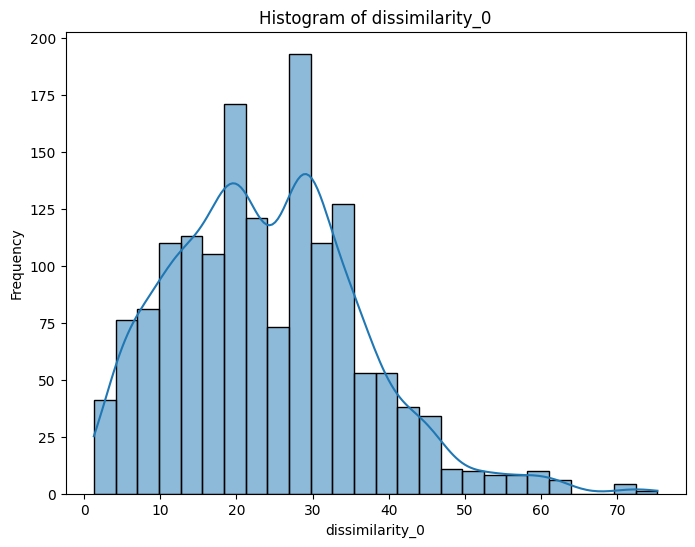

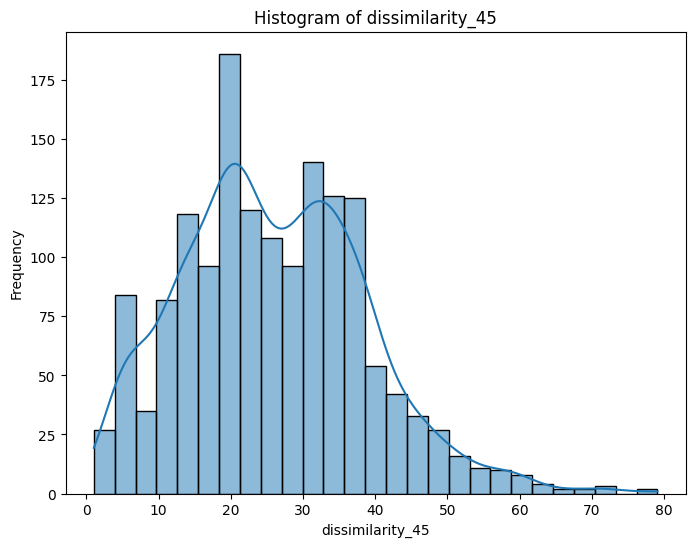

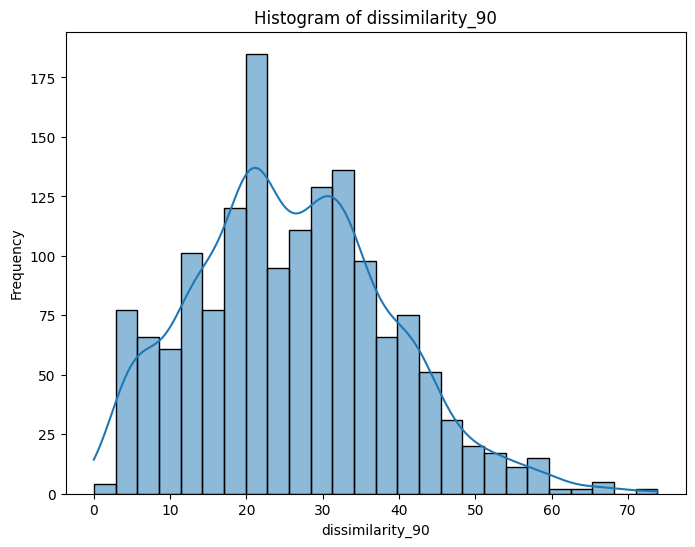

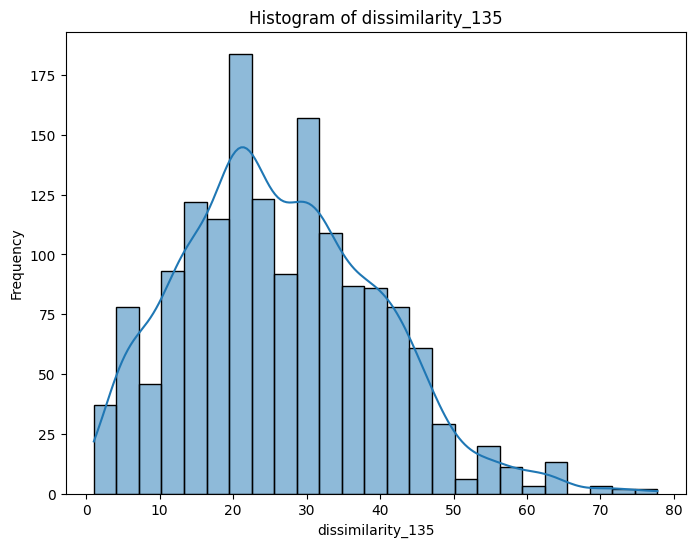

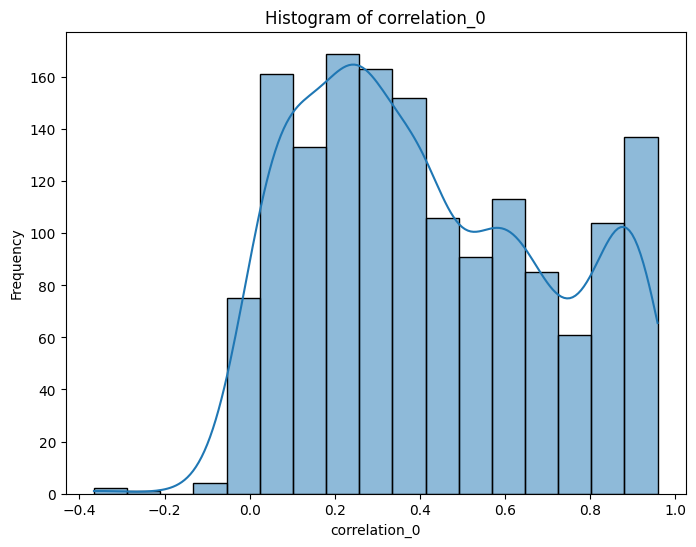

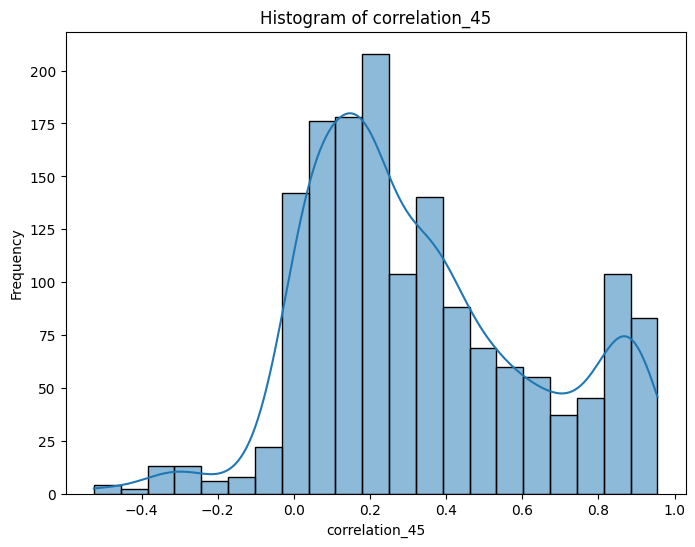

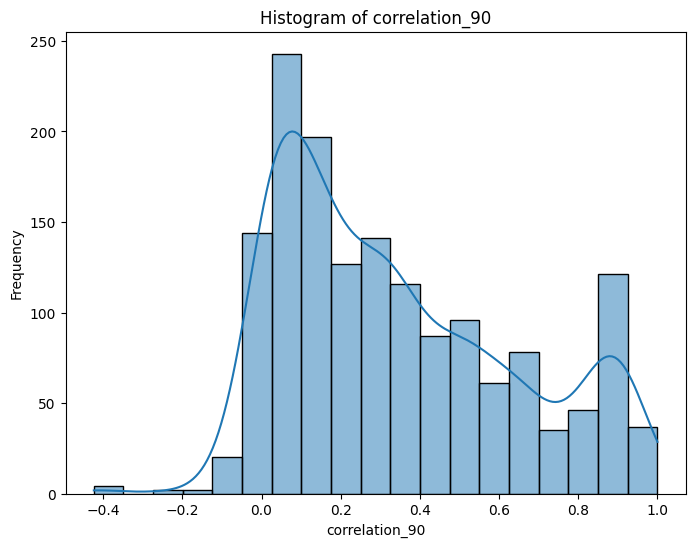

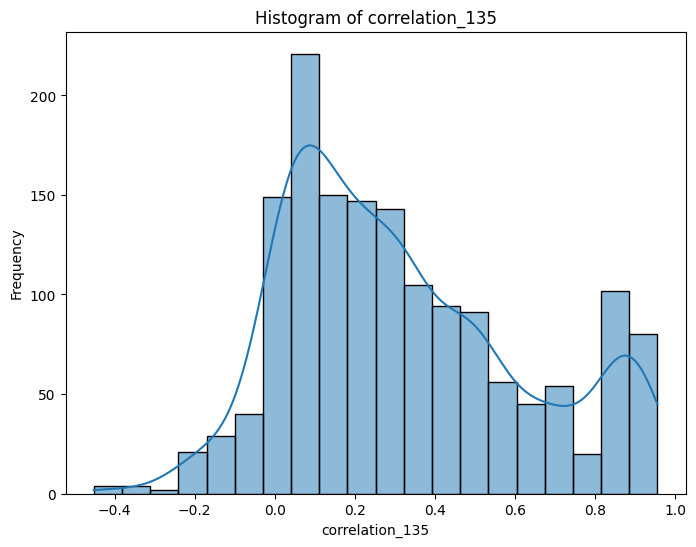

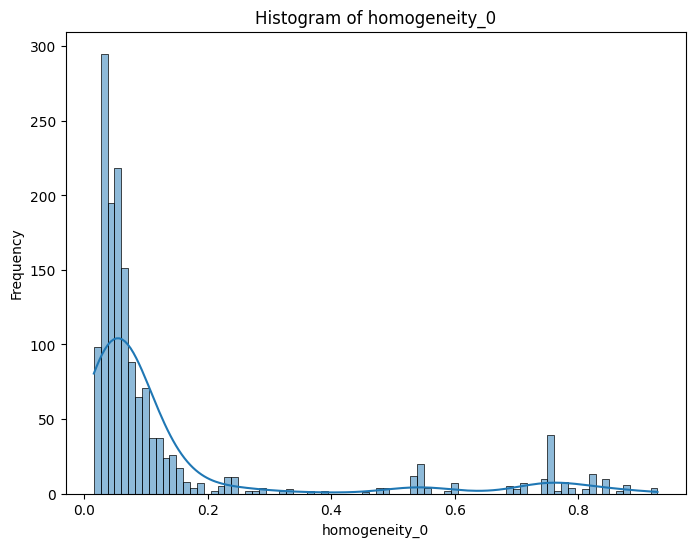

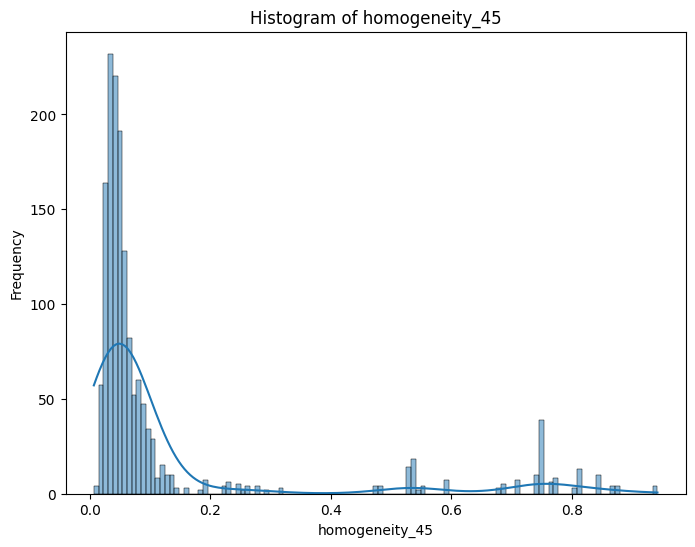

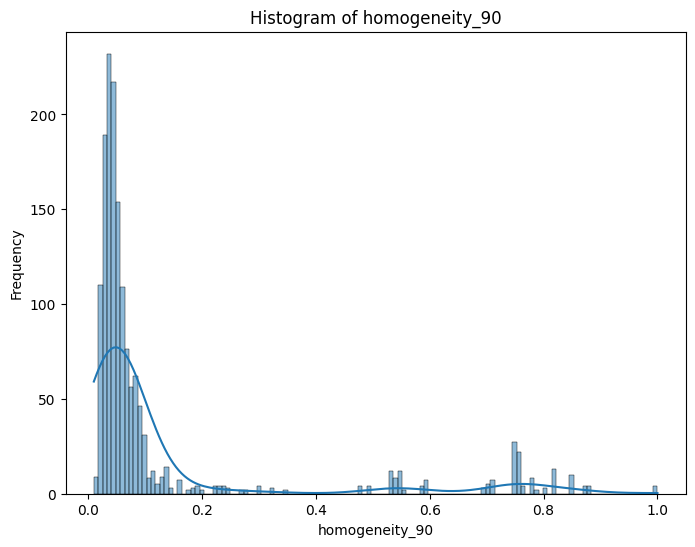

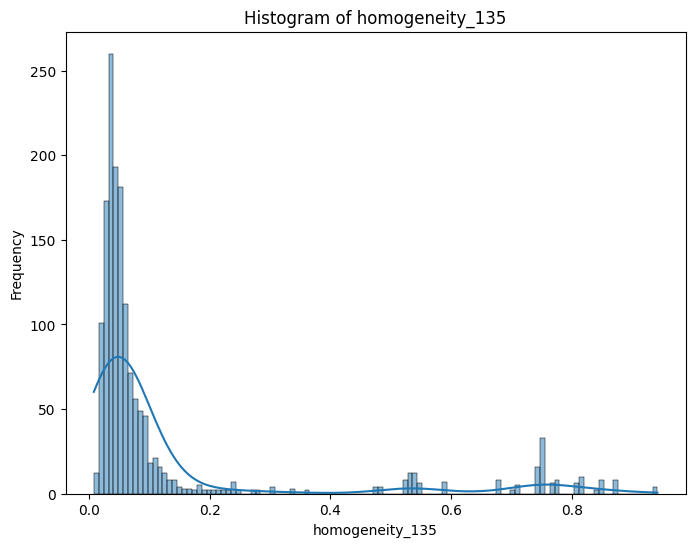

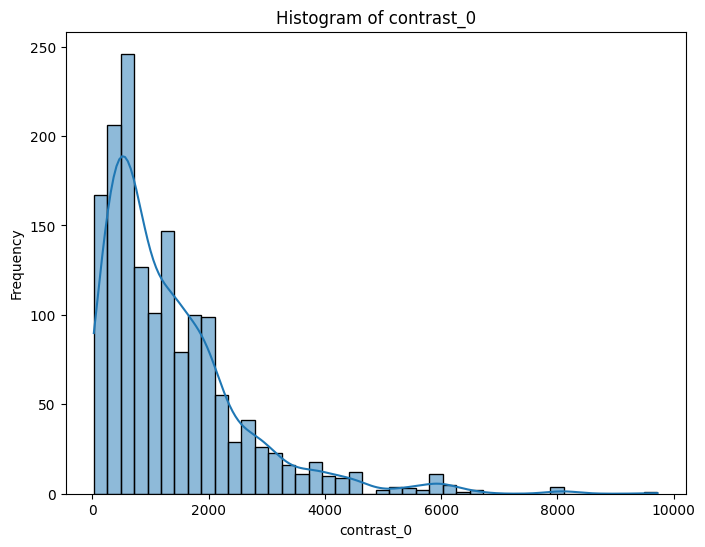

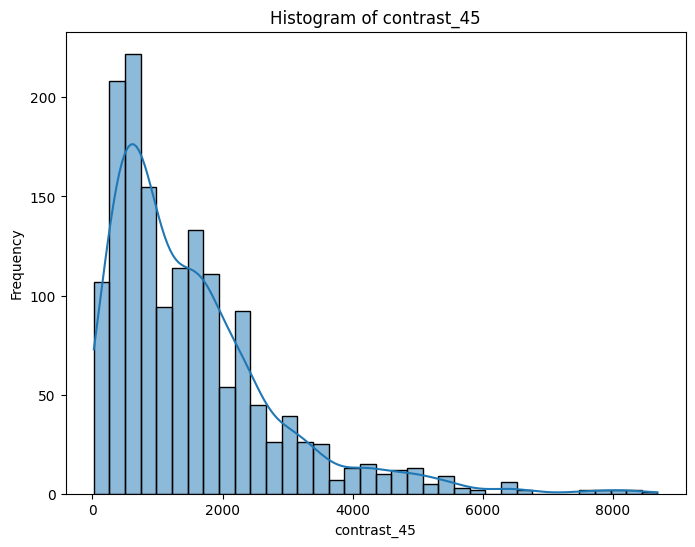

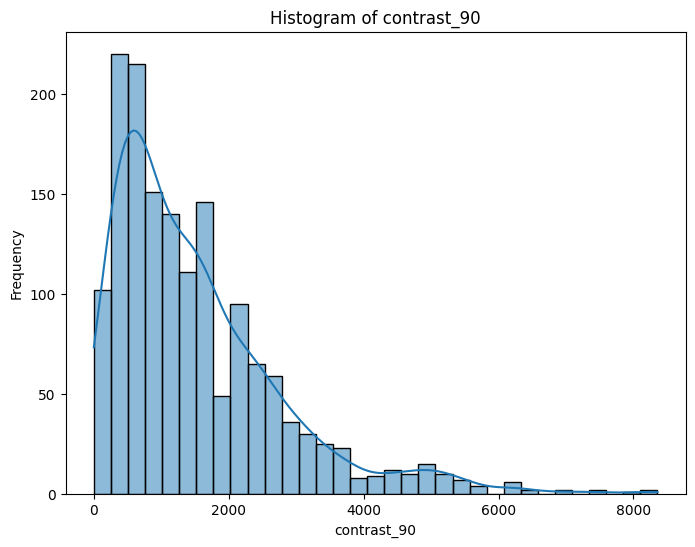

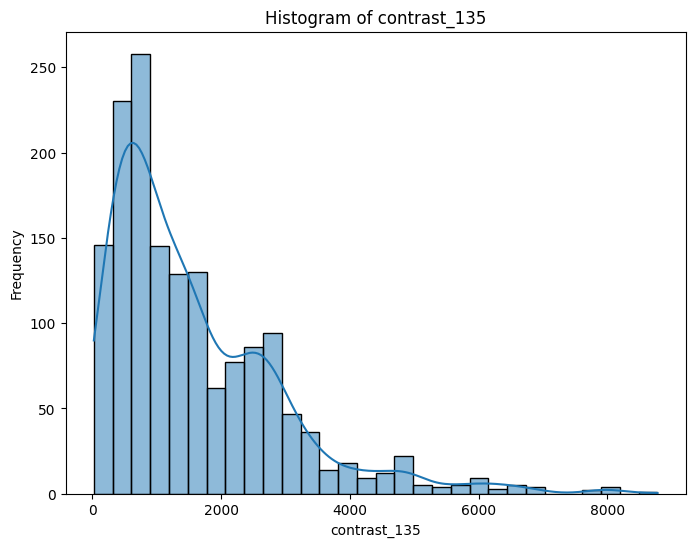

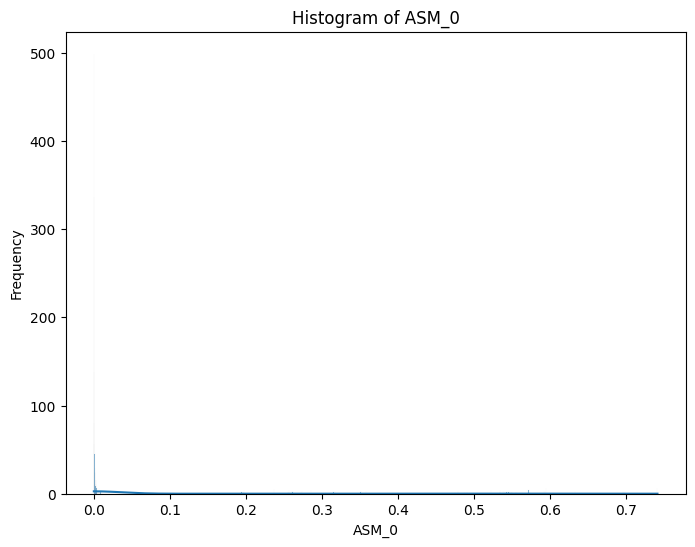

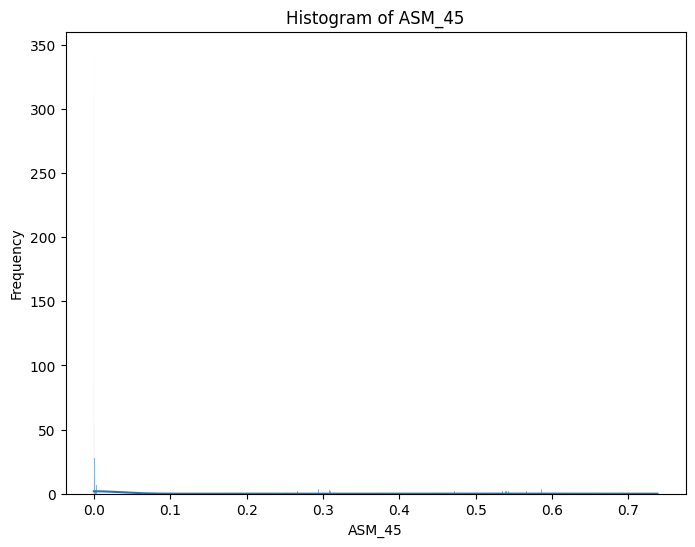

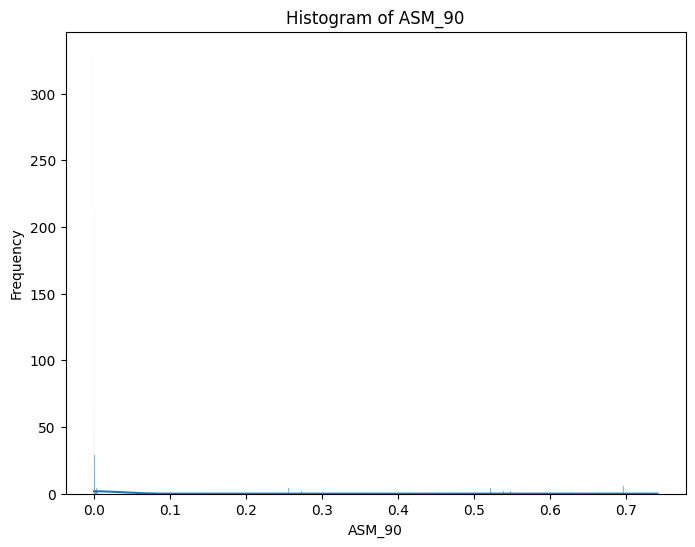

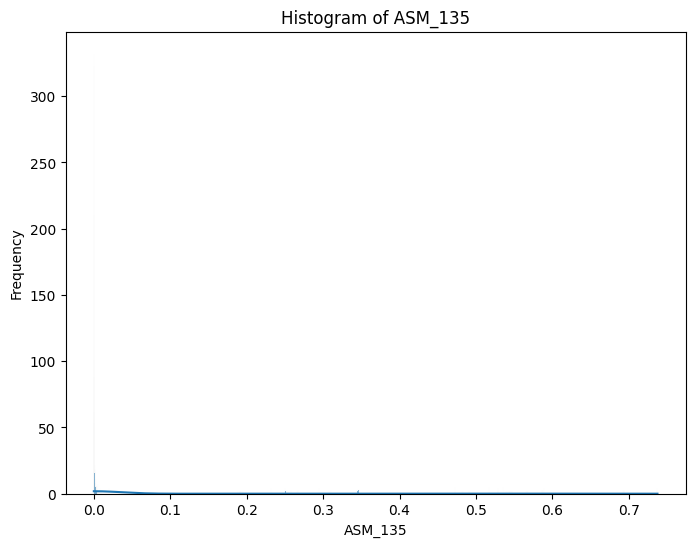

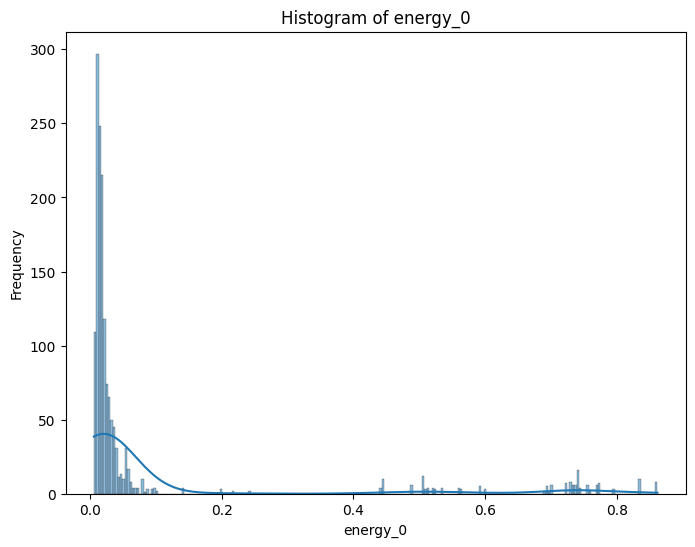

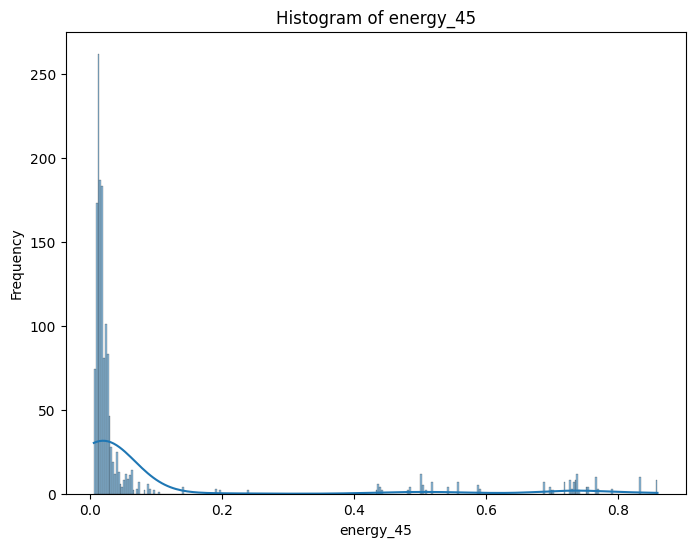

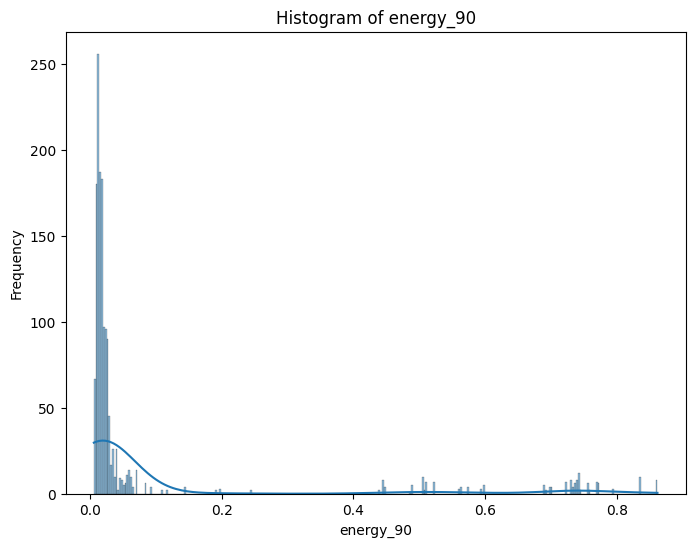

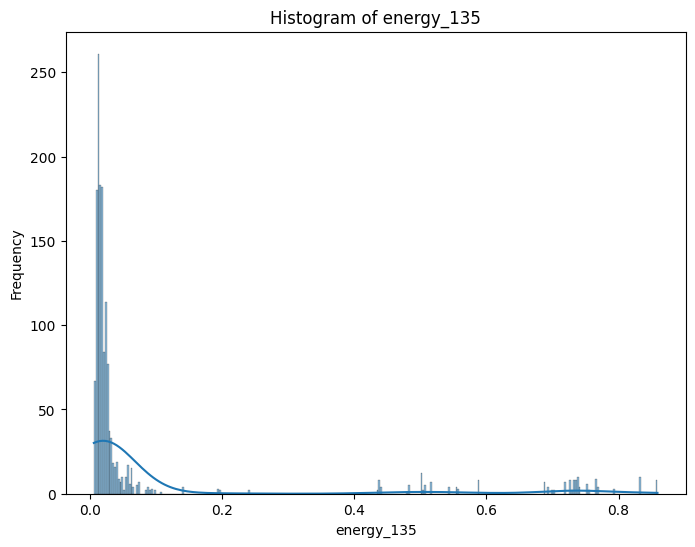

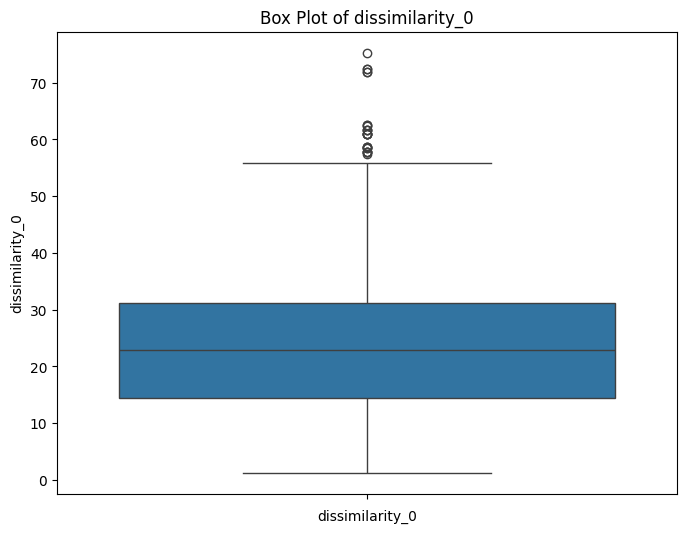

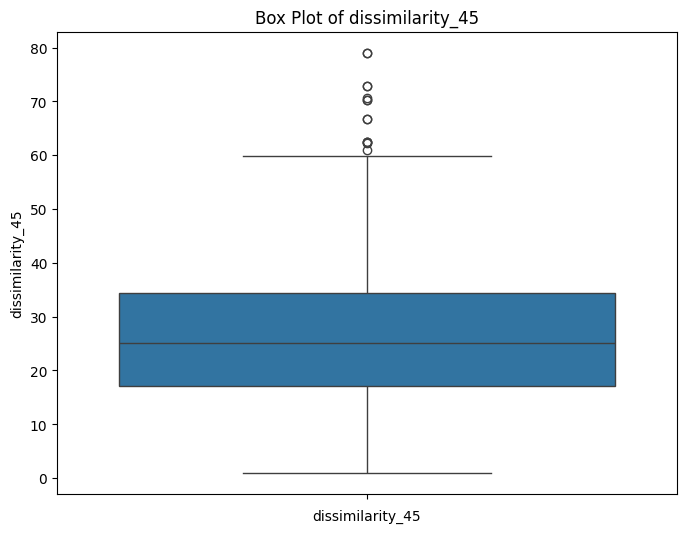

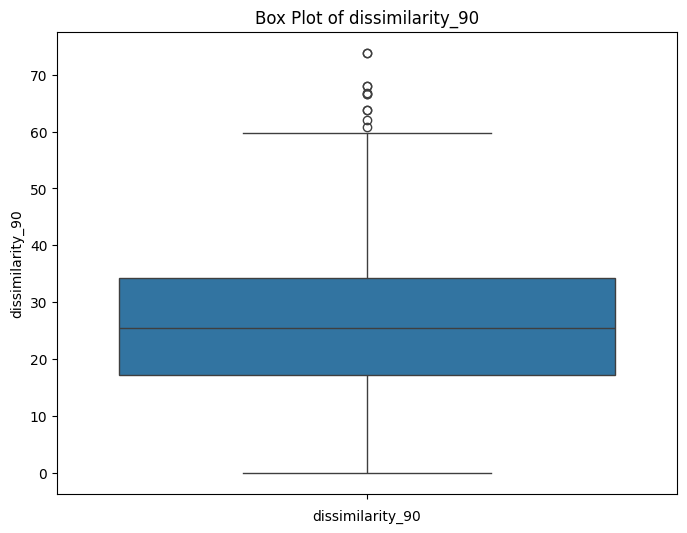

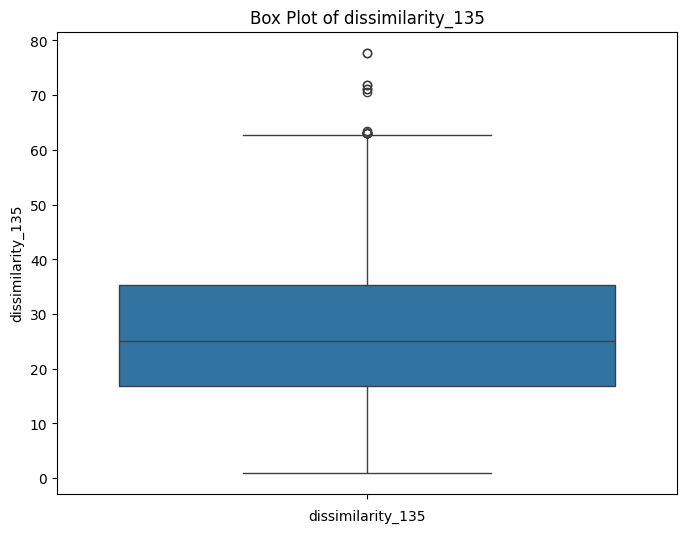

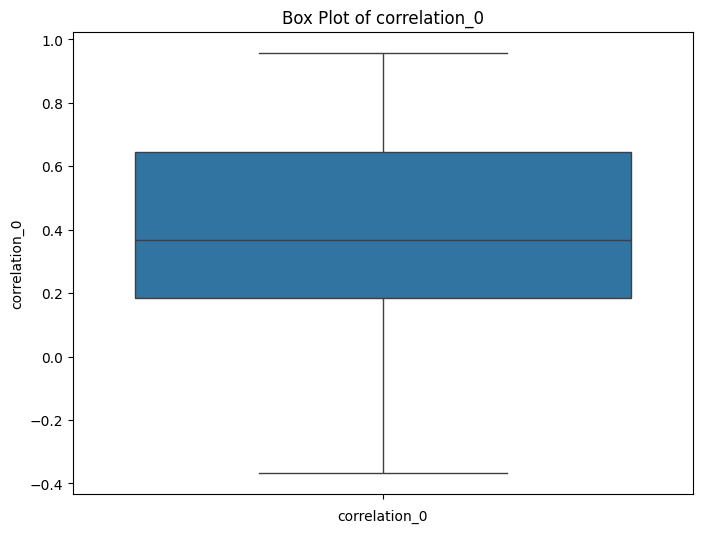

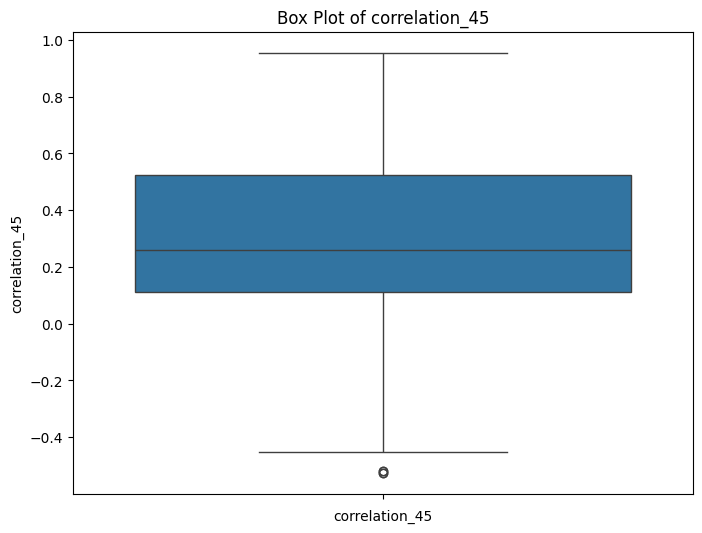

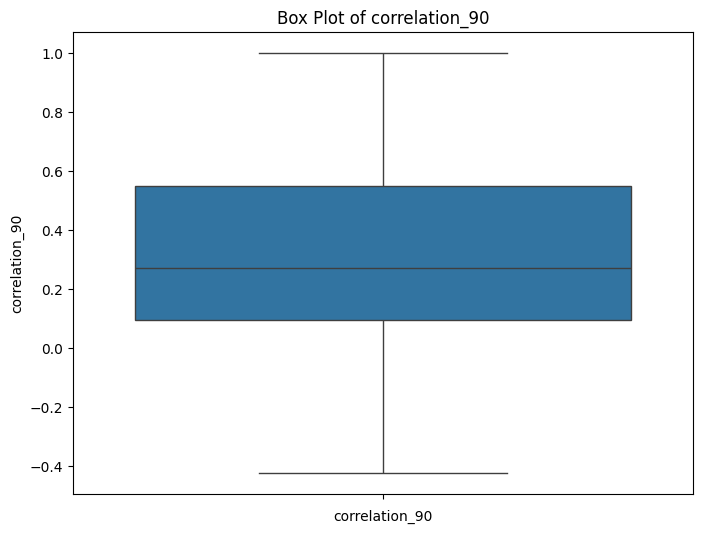

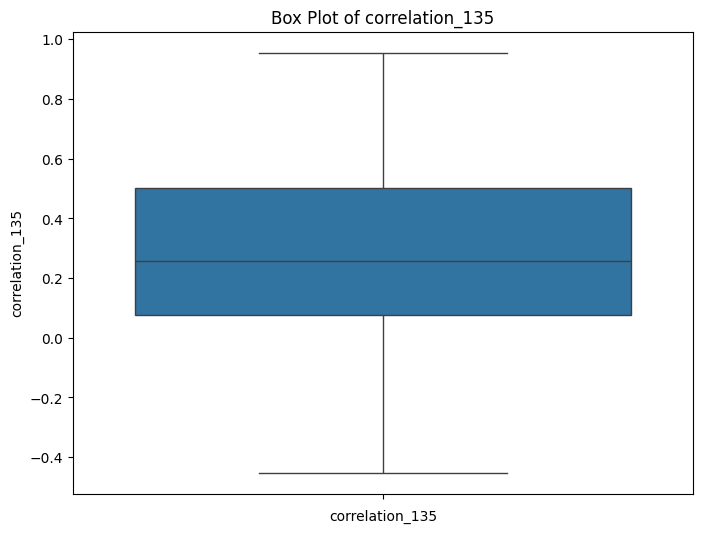

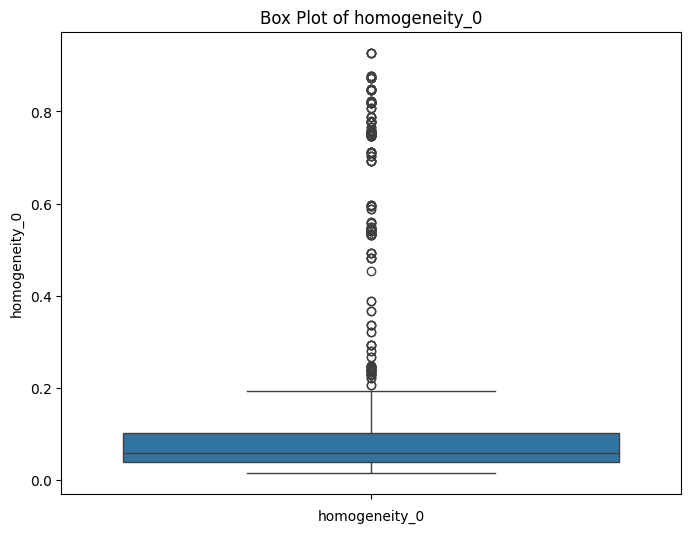

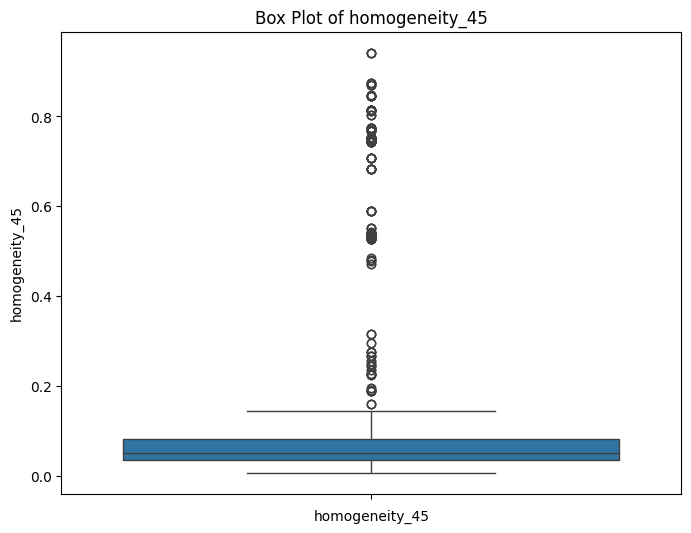

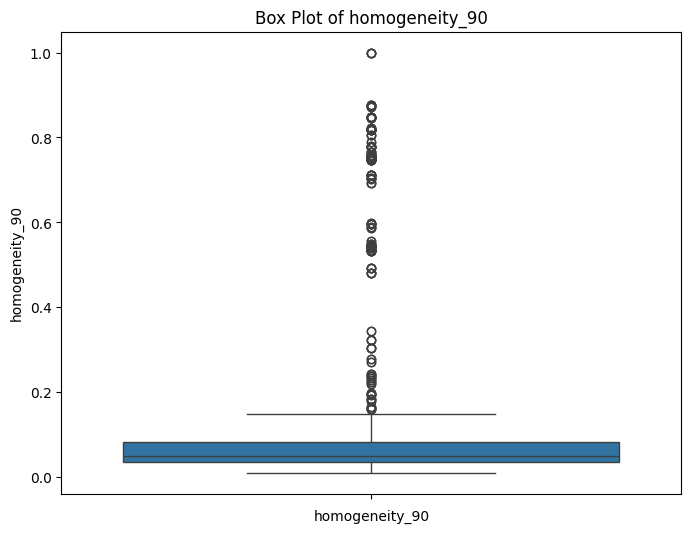

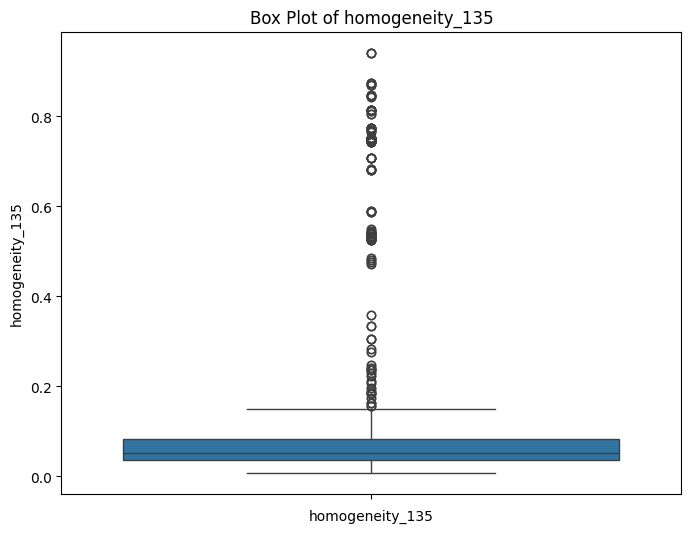

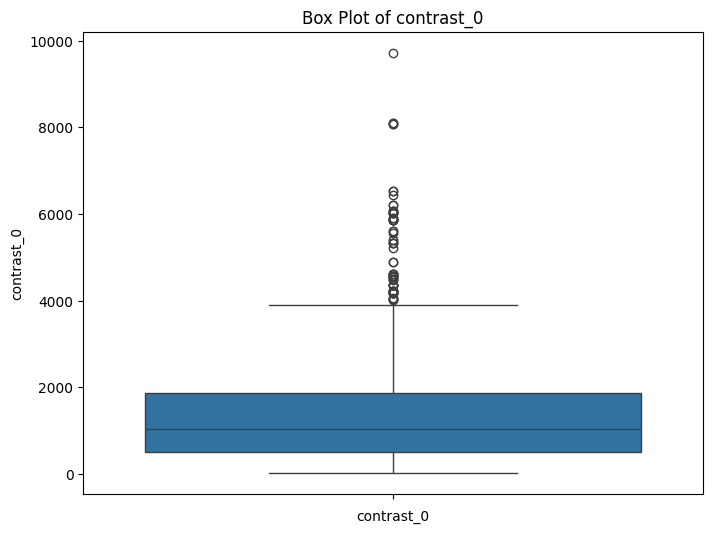

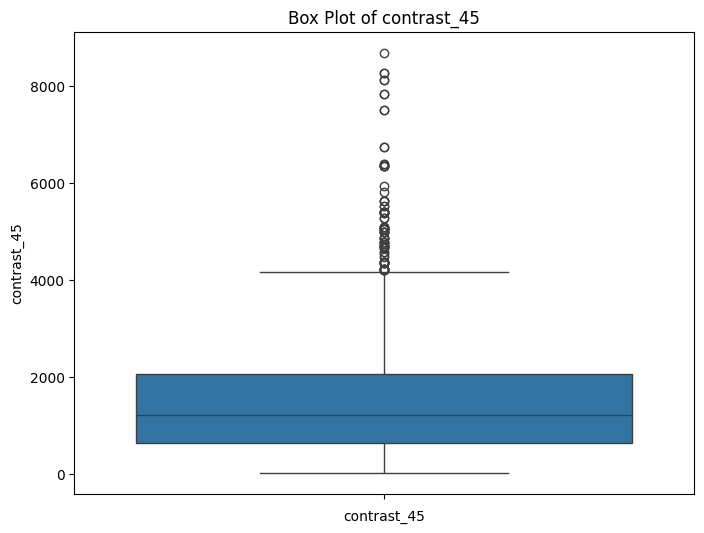

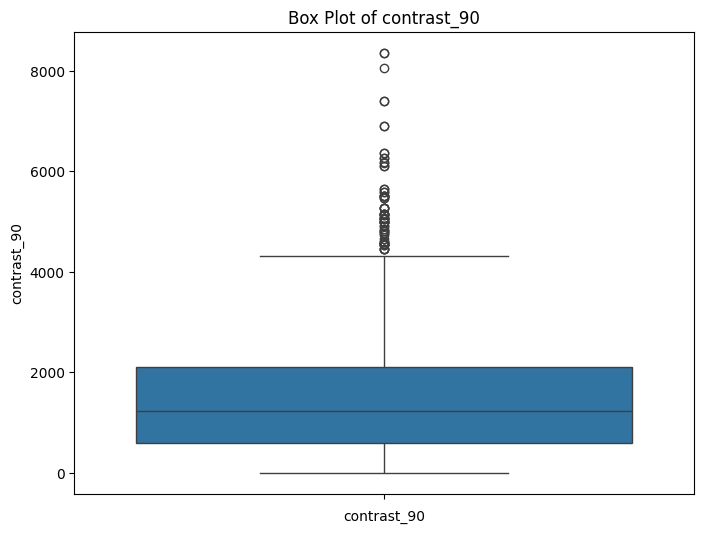

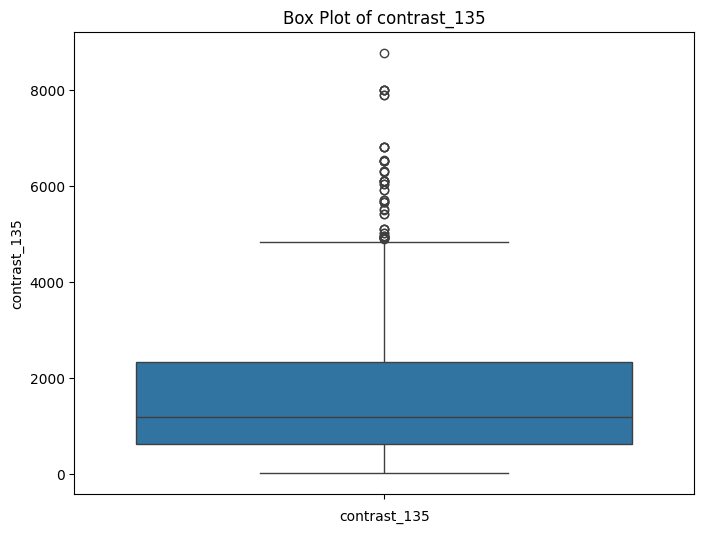

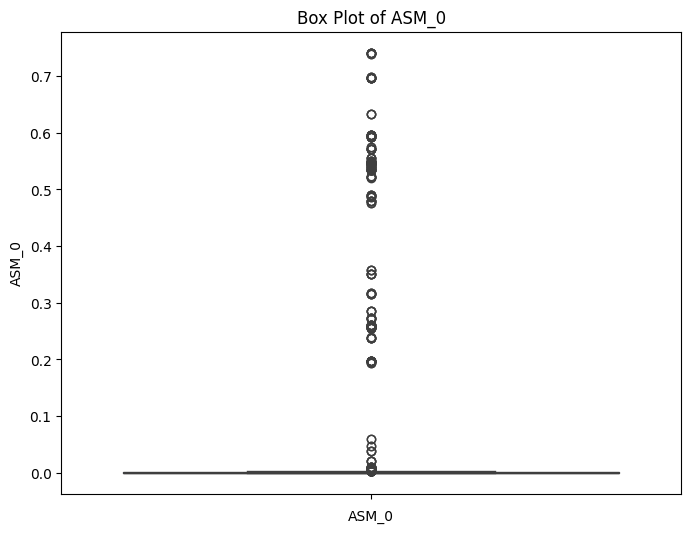

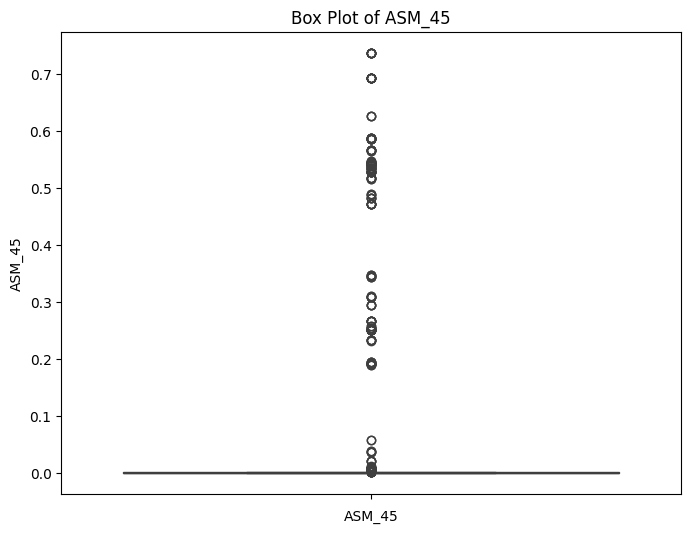

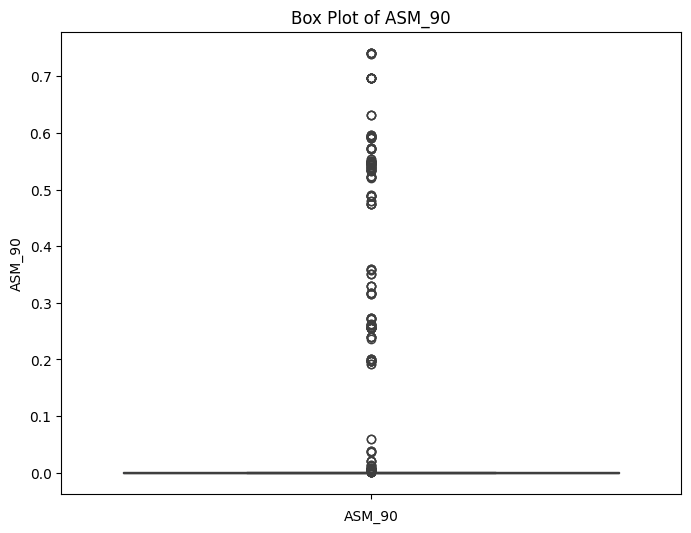

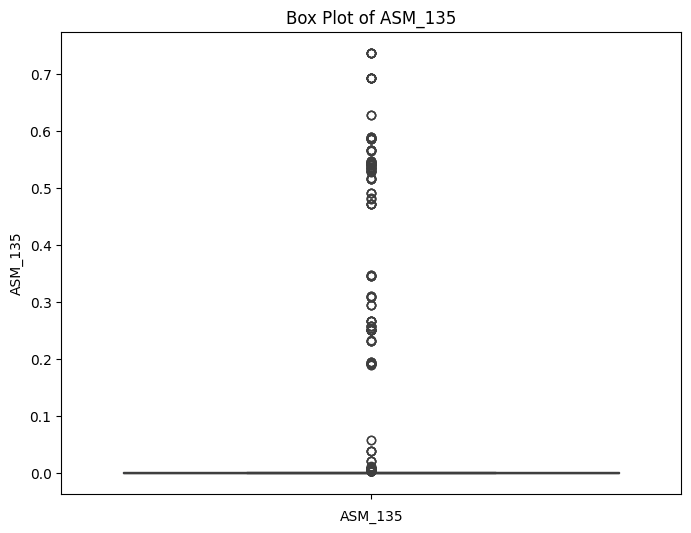

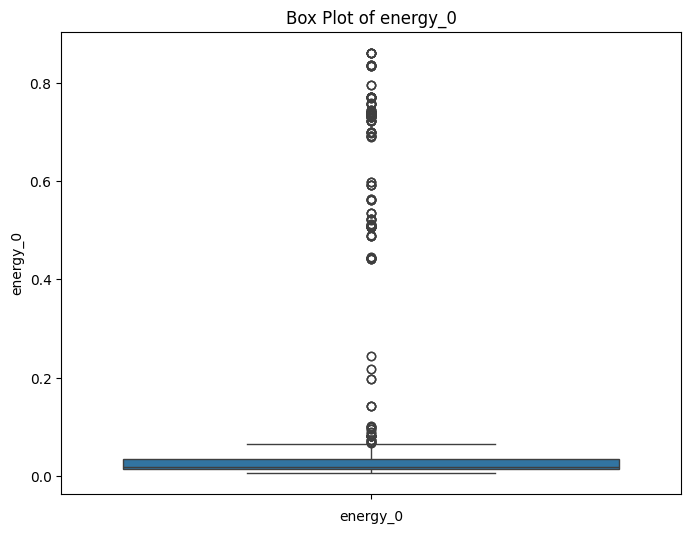

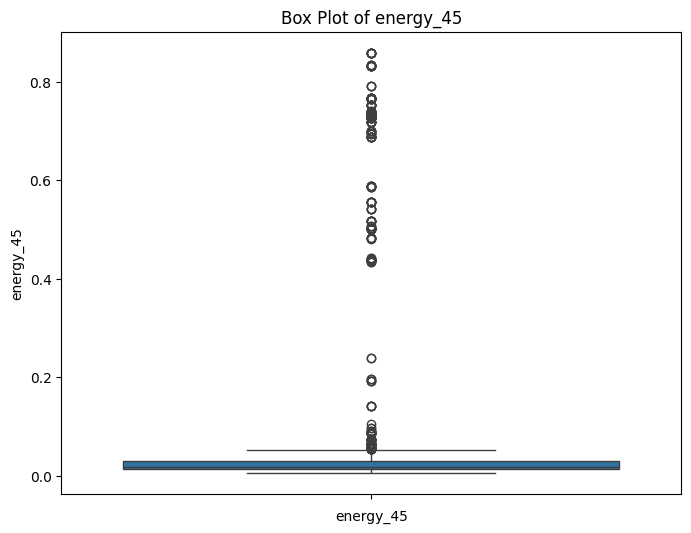

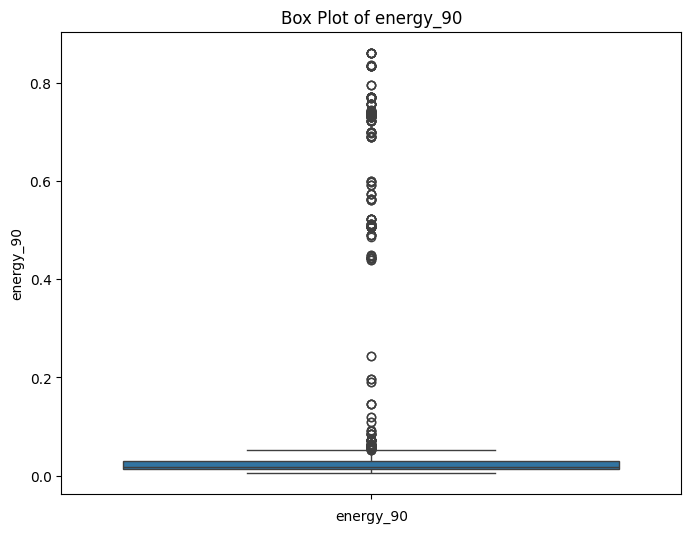

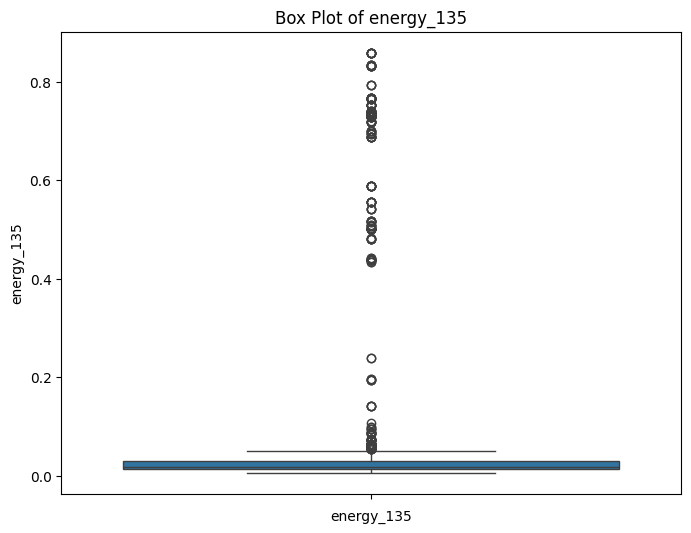

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a DataFrame named df
features = glcm_df.drop(columns=['label'])  # Extracting all features except the label

# Plot histograms for each feature
for column in features.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(features[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Plot box plots for each feature
for column in features.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=features[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

In [14]:
glcm_df['label'].unique()

array(['Black Soil', 'Clay soil', 'Alluvial soil', 'Red soil'],
      dtype=object)

In [15]:
glcm_df.head(20)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135,label
0,17.264660,18.335979,18.548411,18.490954,0.255284,0.133024,0.117905,0.124992,0.054669,0.055324,...,536.499317,0.000310,0.000311,0.000307,0.000312,0.017609,0.017645,0.017518,0.017653,Black Soil
1,38.364171,35.796811,35.933866,39.438942,0.005557,0.121143,0.123396,-0.038545,0.026750,0.028742,...,2414.397388,0.000110,0.000115,0.000113,0.000112,0.010466,0.010707,0.010631,0.010587,Black Soil
2,26.561111,26.534577,27.667824,27.608610,0.141612,0.142929,0.083427,0.080971,0.038653,0.037527,...,1194.448904,0.000166,0.000168,0.000162,0.000166,0.012877,0.012975,0.012721,0.012872,Black Soil
3,12.077756,12.146298,12.335615,12.084356,0.185825,0.127701,0.133605,0.148248,0.086285,0.093907,...,283.144810,0.000908,0.000919,0.000914,0.000914,0.030137,0.030307,0.030239,0.030238,Black Soil
4,9.272283,9.385549,9.434222,9.434664,0.112793,0.086340,0.068770,0.076451,0.104570,0.098324,...,142.388612,0.001156,0.001169,0.001158,0.001159,0.033998,0.034186,0.034026,0.034046,Black Soil
5,19.469246,20.678021,20.436876,20.075488,0.229789,0.112523,0.125933,0.155683,0.091226,0.070744,...,799.434783,0.001740,0.000681,0.000606,0.000739,0.041707,0.026102,0.024609,0.027186,Black Soil
6,31.835240,33.151543,29.689572,32.633735,0.060238,0.021794,0.185231,0.049283,0.035691,0.033571,...,1699.008904,0.000144,0.000145,0.000150,0.000145,0.011980,0.012049,0.012259,0.012033,Black Soil
7,16.573909,18.720387,18.522775,18.121790,0.365099,0.110459,0.078240,0.161636,0.104241,0.081631,...,748.948049,0.001922,0.000819,0.000746,0.000896,0.043836,0.028620,0.027314,0.029937,Black Soil
8,22.328736,23.609160,23.388562,22.979920,0.101808,0.014634,0.015599,0.056846,0.044441,0.040644,...,842.887123,0.000227,0.000223,0.000227,0.000226,0.015052,0.014938,0.015081,0.015033,Black Soil
9,27.186823,27.706411,27.726545,27.554104,0.233625,0.216299,0.210729,0.228749,0.039556,0.040157,...,1243.204037,0.000146,0.000146,0.000145,0.000147,0.012067,0.012083,0.012029,0.012122,Black Soil


In [27]:
glcm_df.to_csv("/content/drive/My Drive/IIITNR_PROJECT/finaldata.csv" ,index=False)

In [16]:
import matplotlib.pyplot as plt
#important libraries and import
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [17]:
# Extract features (X) and labels (y) from the DataFrame
X = glcm_df.drop(columns=['label'])  # Features
y = glcm_df['label']  # Labels

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.fit_transform(X_test)

In [20]:
svc = SVC()
svc.fit(x_train ,y_train)
pred_svc = svc.predict(x_test)
pred_svc

array(['Alluvial soil', 'Clay soil', 'Red soil', 'Black Soil', 'Red soil',
       'Alluvial soil', 'Black Soil', 'Alluvial soil', 'Clay soil',
       'Alluvial soil', 'Red soil', 'Alluvial soil', 'Alluvial soil',
       'Red soil', 'Alluvial soil', 'Red soil', 'Black Soil',
       'Black Soil', 'Red soil', 'Red soil', 'Alluvial soil',
       'Alluvial soil', 'Red soil', 'Clay soil', 'Clay soil',
       'Black Soil', 'Alluvial soil', 'Alluvial soil', 'Red soil',
       'Black Soil', 'Alluvial soil', 'Clay soil', 'Alluvial soil',
       'Alluvial soil', 'Alluvial soil', 'Alluvial soil', 'Red soil',
       'Clay soil', 'Alluvial soil', 'Alluvial soil', 'Black Soil',
       'Clay soil', 'Alluvial soil', 'Red soil', 'Clay soil',
       'Alluvial soil', 'Red soil', 'Alluvial soil', 'Red soil',
       'Alluvial soil', 'Alluvial soil', 'Alluvial soil', 'Alluvial soil',
       'Alluvial soil', 'Alluvial soil', 'Alluvial soil', 'Red soil',
       'Clay soil', 'Alluvial soil', 'Black Soil', 'Allu

In [21]:
print(classification_report(y_test, pred_svc))

               precision    recall  f1-score   support

Alluvial soil       0.57      0.71      0.64       178
   Black Soil       0.80      0.61      0.70       114
    Clay soil       0.64      0.58      0.61        72
     Red soil       0.60      0.54      0.57       104

     accuracy                           0.63       468
    macro avg       0.65      0.61      0.63       468
 weighted avg       0.65      0.63      0.63       468



In [22]:
##finding best parameter for our SVC model
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [0.1 ,0.8,0.9,1,1.1,1.2,1.3,1.4,3,5,7,8,9,10,12],
    'kernel' : ['linear' , 'rbf'],
    'gamma' : [0.1 ,0.8,0.9,1,1.1,1.2,1.3,1.4,2,4,6,8,10]

}

grid_svc= GridSearchCV(svc , param_grid = params , scoring = 'accuracy' , cv = 10)

In [23]:
grid_svc.fit(x_train , y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 3, 5, 7, 8,
                               9, 10, 12],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 2, 4,
                                   6, 8, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [24]:
grid_svc.best_params_

{'C': 5, 'gamma': 8, 'kernel': 'rbf'}

In [25]:
svc2 = SVC( C = 5 , gamma = 8 , kernel = 'rbf')
svc2.fit(x_train , y_train)
pred_svc2 = svc2.predict(x_test)
print(classification_report(y_test , pred_svc2))

               precision    recall  f1-score   support

Alluvial soil       0.93      0.90      0.92       178
   Black Soil       0.97      0.82      0.89       114
    Clay soil       0.98      0.68      0.80        72
     Red soil       0.66      0.94      0.77       104

     accuracy                           0.86       468
    macro avg       0.88      0.84      0.85       468
 weighted avg       0.89      0.86      0.86       468



comparison SVM
